# Attempt to Model Velocity Dependence
Using the multiple runs from the Si dataset

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_qbox_data
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import os

## Load in Data
Read in data from all velocities

In [2]:
def load_directory(d):
    """Load in a directory holding a single trajectory
    
    :param d: Path to directory"""
    
    # Read in the data files
    data = []
    for file in tqdm(glob('%s/*.out'%d), desc='Files', leave=False):
        # LW 20Oct17: This function can be a parsel app call
        frame = load_qbox_data(file)
        frame['file'] = file
        data.append(frame)
    data = pd.concat(data)
    
    # Sort, assign timestep values
    data.sort_values(['file_id', 'frame_id'], ascending=True, inplace=True)
    data['timestep'] = list(range(len(data)))
    data.set_index('timestep', inplace=True, drop=False)
    
    # Compute displacement
    data['displacement'] = (data['position'] - data['position'][0]).apply(np.linalg.norm)
    
    # Add tag for the directory
    data['directory'] = d
    
    return data
    

Load in all directories

In [3]:
files = glob('Si/v**/*.out')
dirs = set([os.path.dirname(x) for x in files])
print('Found %d files in %d directories'%(len(files), len(dirs)))

Found 13 files in 8 directories


In [4]:
data = [load_directory(d) for d in tqdm(dirs, desc='Directories')]

In [5]:
data = pd.concat(data)

How much data from each type?

In [6]:
for gid, group in data.groupby('directory'):
    print(gid, len(group))

Si/v_0.125 16848
Si/v_0.25 8424
Si/v_0.5 4212
Si/v_0.75 2808
Si/v_1.0 2106
Si/v_1.5 1404
Si/v_2.0 1053
Si/v_5.0 842


## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

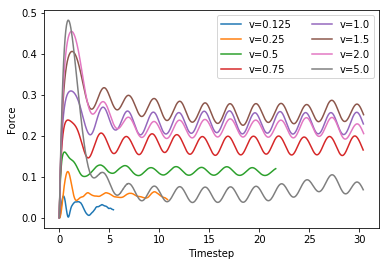

In [7]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)
    
ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

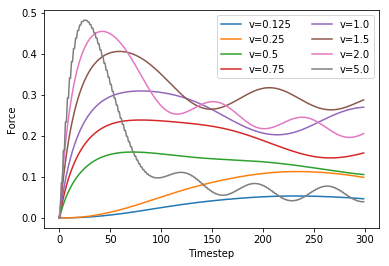

In [8]:
fig, ax = plt.subplots()

plot_max = 300
for gid, group in data.groupby('directory'):
    ax.plot(group['timestep'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)
    
ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

After 125 seems good

In [9]:
data.query('timestep >= 125', inplace=True)

## Load in the Charge Density
Get the ground state charge density without the particle. Plot it to make sure it looks correct

In [10]:
charge, cell = get_charge_density_interpolator(os.path.join('Si',
                                                            'charge_density_ground_state_bulk_si',
                                                            'Si_4_val_elec_gs.cub'))

Plot the charge density along the [1,0,0] direction. Should be 4 bumps (one is split)

Plot the charge density along the [1,1,0] direction. Should be 8 bumps (one is split)

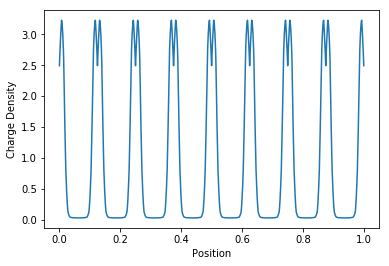

In [11]:
fig, ax = plt.subplots()

x = np.array(list(zip(np.linspace(0,1,1001), np.linspace(0,1,1001), [0,]*1001)))

ax.plot(x[:,0], charge(x))

ax.set_xlabel('Position')
ax.set_ylabel('Charge Density')

## Generate Features
Use the same features at the Al model

In [12]:
featurizers = [
    LocalChargeDensity(charge, np.linspace(1, -5, 7)),
    ProjectedAGNIFingerprints(etas=np.logspace(np.log10(0.8), np.log10(16), 8)),
    IonIonForce(acc=2)
]

In [13]:
%%time
for f in featurizers:
    data = f.featurize_dataframe(data, 'atoms', n_jobs=None)

CPU times: user 17.9 s, sys: 7.79 s, total: 25.6 s
Wall time: 35min 15s


In [14]:
X_cols = sum([f.feature_labels() for f in featurizers], [])
y_col = 'force'

## Fit on Entire Dataset
Use Bayesian Ridge Regression. Train on progressively larger slices, and see how the model does.

In [15]:
def fit_on_whole_dataset(model):

    model.fit(data[X_cols], data[y_col])

    fig, ax = plt.subplots()

    for gid, group in data.groupby('directory'):
        my_line, = ax.plot(group['displacement'], group['force'], linestyle='--', label=gid[3:].replace("_","="))

        ax.plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)

    ax.legend(ncol=2)

    ax.set_xlabel('Timestep (a.u.)')
    ax.set_ylabel('Force ($E_H / a_B$)')

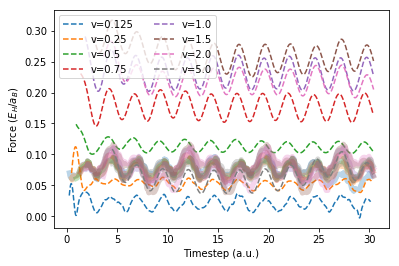

In [16]:
fit_on_whole_dataset(BayesianRidge(normalize=True))

You'll note the model predictions (thick, translucent lines) do not really differ based on velocity

## Add Velocity as a Variable
Can we fit the data if we just add velocity as a variable.

In [17]:
data['velocity_mag'] = data['velocity'].apply(np.linalg.norm)

In [18]:
X_cols += ['velocity_mag',]

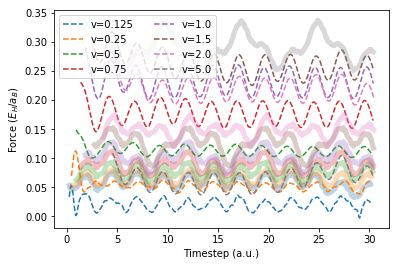

In [19]:
fit_on_whole_dataset(BayesianRidge(normalize=True))

The predictions do at least change significantly with the velocity, but not very well

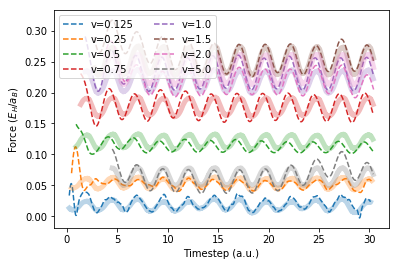

In [24]:
fit_on_whole_dataset(MLPRegressor(activation='tanh', hidden_layer_sizes=(128,64,32,16)))

With a somewhat complex NN model, we can at least fit the data

In [25]:
data[['directory',] + X_cols + [y_col,]].to_csv('Si_all_velocities.csv', index=False)